In [63]:
library(tidyverse)
library(patchwork)

In [2]:
hungarian_data <- read_delim("proposal rough work/processed.hungarian.data", delim = ",", col_names = FALSE)
colnames(hungarian_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

cleveland_data <- read_delim("proposal rough work/processed.cleveland.data", delim = ",", col_names = FALSE)
colnames(cleveland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

switzerland_data <- read_delim("proposal rough work/processed.switzerland.data", delim = ",", col_names = FALSE)
colnames(switzerland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

va_data <- read_delim("proposal rough work/processed.va.data", delim = ",", col_names = FALSE)
colnames(va_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")



stacked_data <- rbind(hungarian_data, va_data, switzerland_data, cleveland_data)
# stacked_data
# write_tsv(hungarian_data, "data/hungarian_data.tsv")

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

In [80]:
editedData <- stacked_data


for(i in 1:nrow(editedData)) {       # for-loop over rows
    if(editedData$sex[i] == 1){
      editedData$sex[i] <- "male"
    }else{
      editedData$sex[i]<- "female"
      }

    if(editedData$chest_pain_type[i] == 1){
      editedData$chest_pain_type[i] <- "typical angina"
    }

    if(editedData$chest_pain_type[i] == 2){
      editedData$chest_pain_type[i] <- "atypical angina"
    }

    if(editedData$chest_pain_type[i] == 3){
      editedData$chest_pain_type[i] <- "non-anginal pain"
    }

    if(editedData$chest_pain_type[i] == 4){
      editedData$chest_pain_type[i] <- "asymptomatic"
    }
}

head(editedData)

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,male,atypical angina,130,132,0,2,185,0,0,?,?,?,0
29,male,atypical angina,120,243,0,0,160,0,0,?,?,?,0
29,male,atypical angina,140,?,0,0,170,0,0,?,?,?,0
30,female,typical angina,170,237,0,1,170,0,0,?,?,6,0
31,female,atypical angina,100,219,0,1,150,0,0,?,?,?,0
32,female,atypical angina,105,198,0,0,165,0,0,?,?,?,0


In [86]:
#Removing Incorrect 0 Values
editedData <- editedData |>
    filter(age != 0) |>
    filter(rest_bp != 0) |>
    filter(serum_cholesterol != 0) |>
    filter(max_heartrate != 0)

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message:
“Removed 30 rows containing missing values (`geom_point()`).”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message:
“Removed 46 rows containing missing values (`geom_point()`).”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message:
“Removed 45 rows containing missing values (`geom_point()`).”


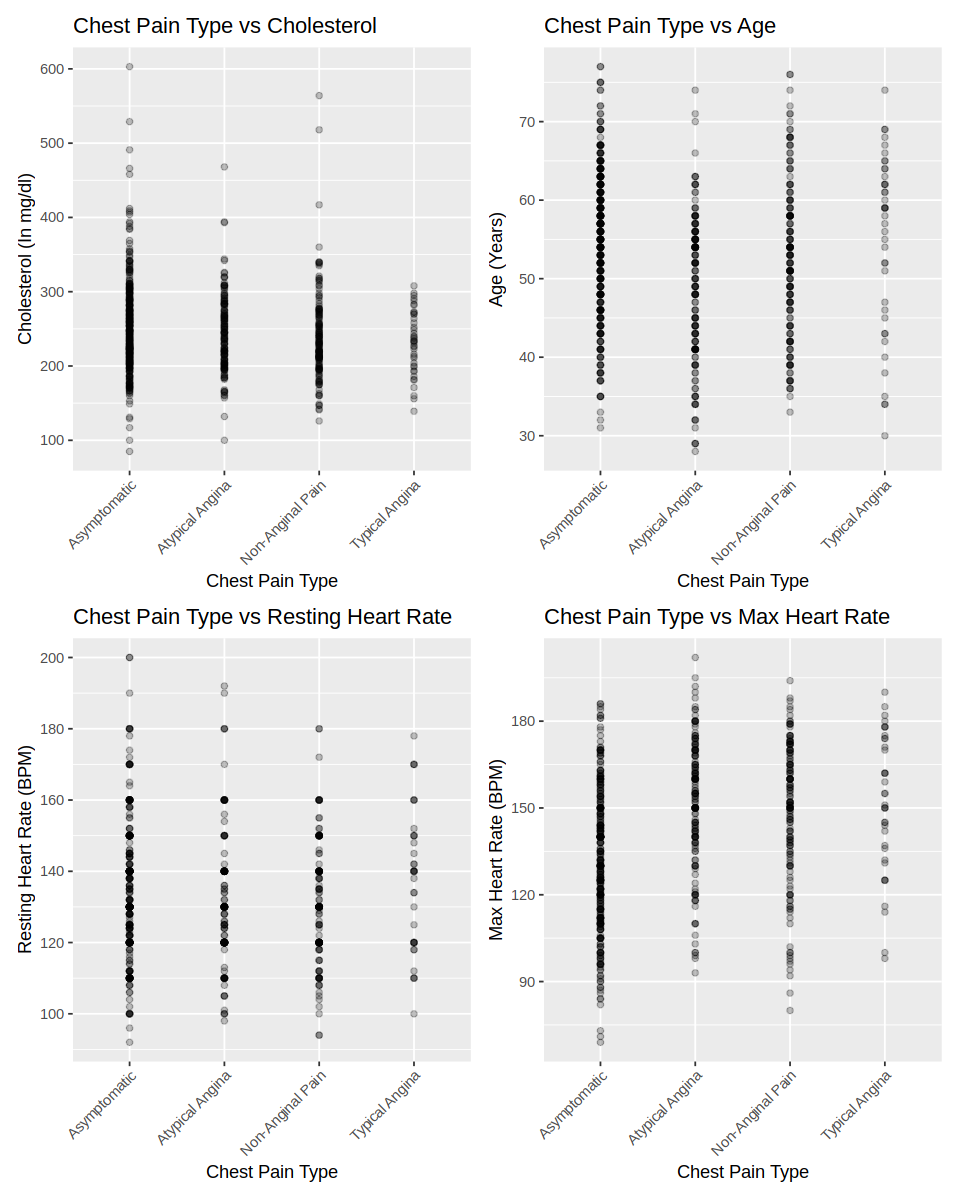

In [90]:
#Making scatter Plot

options(repr.plot.height = 10, repr.plot.width = 8)
#serum_cholesterol, age, rest_bp, max_heartrate

PainVsSerum <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = as.numeric(serum_cholesterol))) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Chest Pain Type vs Cholesterol") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Cholesterol (In mg/dl)", breaks = seq(0, 700, by = 100)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsAge <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = age)) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Chest Pain Type vs Age") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Age (Years)", breaks = seq(0, 100, by = 10)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsRHR <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = as.numeric(rest_bp))) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Chest Pain Type vs Resting Heart Rate") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Resting Heart Rate (BPM)", breaks = seq(0, 200, by = 20)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsMHR <- editedData |> 
    ggplot(aes(x = chest_pain_type, y = as.numeric(max_heartrate))) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Chest Pain Type vs Max Heart Rate") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Max Heart Rate (BPM)", breaks = seq(0, 300, by = 30)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsSerum + PainVsAge + PainVsRHR + PainVsMHR +
  plot_layout(ncol = 2)
# ageVsSerum

***Heart Disease Classification Using KNN***

Group project-003-21



***Introduction***

**Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal**

Heart disease refers to a range of conditions that affect the heart. Various factors, such as age, lifestyle, and genetics, can influence the chances of an individual getting heart disease. We want to understand what factors are related to certain chest pain types.

The dataset that we will be using is titled “Heart Disease,” created by Andras Janosi, William Steinbrunn, Matthias Pfisterer, Robert Detrano. It was donated to the UC Irvine Machine Learning Repository on June 30th, 1998.

This data set contains observations with a total of 76 attributes, collected from various patients. These observations have been processed and published as 4 separate experiment databases, each of which only includes the same subset of 14 attributes, one of which is a predicted class. For ease of reading data, we selected our data from the processed experiment files, and have combined the data from Cleveland, Hungary, Switzerland, and the VA Long Beach.

From the 14 available variables, we have chosen to focus on age, chest pain type, resting blood pressure and cholesterol levels, and plan to determine how chest pain type correlates with age, resting blood pressure and cholesterol levels. 

Following is a description of each of these 4 variables. Note that the column names in parentheses are not from the original data:

**Age (age): the age of the patient**

**Cholesterol Level (cholesterol_level): serum cholesterol level in milligrams per decilitre**

**Chest Pain Type (chest_pain_type): a value from 1-4 describing the type of chest pain in the individual**
1. typical angina
2. atypical angina
3. non-anginal pain
4. asymptomatic

**Resting Blood Pressure (trestbps): resting blood pressure (in mm Hg on admission to the hospital)**


***Research Question***

Can we determine what type of chest pain a patient is likely experiencing based on only their age and cholesterol levels?

***Preliminary exploratory data analysis:***

To read the data, we first downloaded the data set from the UCI Machine Learning Repository.  We then looked through the data files and combined the data of Cleveland, Hungary, Switzerland, and the VA Long Beach into one table. 

After reading the file and looking through the heart-disease.names file for the descriptions of each attribute, we gave the table columns appropriate names to ensure the data would be understandable. 

Below is the data with added column names, we chose to show two observations:


In [5]:
demoData <- stacked_data |> head(2)
demoData

#Figure 1: Combined data of Cleveland, Hungary, Switzerland, and the VA Long Beach with added column names

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0


After summarizing the data for our analysis and tidying the data, our new data set looks like this.

In [6]:
demodataNewTitles <- editedData |> select(age, serum_cholesterol, chest_pain_type, rest_bp) |> head(2)
demodataNewTitles

#Figure 2: Combined data of Cleveland, Hungary, Switzerland, and the VA Long Beach with columns of interest.

age,serum_cholesterol,chest_pain_type,rest_bp
<dbl>,<chr>,<chr>,<chr>
28,132,atypical angina,130
29,243,atypical angina,120


Since our analysis will be of classification, we need to create a scatter plot for this analysis, we used age and cholesterol as an example.

The plot looks like this:


In [7]:
#Making scatter Plot
editedData

#options(repr.plot.height = 10, repr.plot.width = 10)
#serum_cholesterol, age, rest_bp, max_heartrate
#ageVsSerum <- editedData |> ggplot(aes(x = age, y = serum_cholesterol, color = chest_pain_type)) + 
#                            geom_point() + labs(x="Age (In Years)", y = "Cholesterol (In mg/dl)", color = "Chest Pain Type", title="Age vs Cholesterol") +
#  theme(
#    axis.title.x = element_text(size = 20),
#    axis.title.y = element_text(size = 20),  plot.title = element_text(size = 20))

#ageVsSerum

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,male,atypical angina,130,132,0,2,185,0,0,?,?,?,0
29,male,atypical angina,120,243,0,0,160,0,0,?,?,?,0
29,male,atypical angina,140,?,0,0,170,0,0,?,?,?,0
30,female,typical angina,170,237,0,1,170,0,0,?,?,6,0
31,female,atypical angina,100,219,0,1,150,0,0,?,?,?,0
32,female,atypical angina,105,198,0,0,165,0,0,?,?,?,0
32,male,atypical angina,110,225,0,0,184,0,0,?,?,?,0
32,male,atypical angina,125,254,0,0,155,0,0,?,?,?,0
33,male,non-anginal pain,120,298,0,0,185,0,0,?,?,?,0


***Methods***

In our analysis, we are going to use Age, Cholesterol, and Resting Blood Pressure as our three quantitative data, to predict the type of Chest Pain which is categorical. Using k-nn classification we will be able to do this.


A scatter plot will be used to visualize the data as it allows us to report the values of the data as well as visualize the patterns of the data as a whole. It allows us to determine the strength of the relationship between two variables and makes the data easy to understand and interpret. This allows us to determine what type of chest pain a patient is likely experiencing based on only their age and cholesterol levels. 


***Expected outcomes and significance***

What do you expect to find?
- Age and Chest Pain: The data may reveal patterns that suggest certain types of Chest Pain are more prevalent in specific Age groups.
  
- Cholesterol and Chest Pain: Higher Cholesterol levels may be associated with a higher likelihood of developing Chest Pain.
  
- Resting Blood Pressure and Chest Pain: Higher Resting Blood Pressure levels may be associated with a higher likelihood of developing a certain Chest Pain.


What impact could such findings have?
- Risk assessment: Healthcare providers can use these findings to improve risk assessment for patients.
  
- Treatment Strategies and Recommendations: Providing treatment strategies to specific patient groups based on the age and the level of cholesterol.
  
- Precaution: These findings can provide information to preventive care measures, such as suggesting cholesterol-low intervention for younger adults with a family history of heart disease.
  
- Developing new treatment and drugs: These findings can help to discover new treatments and drugs that can improve the treatments and prevention of disease.
  
- Reducing health care/operation costs: Through this finding more economical treatments can be found to help efficiently reduce health care costs.

What future questions could this lead to?
- How does the data from Hungary compare to one of the other data set from Switzerland, Cleveland and VA Long Beach
  
- One future question if we find a pattern between the types of chest pain and the 2 variables is, Why age/different levels of cholesterol result/resting blood pressure in different types of chest pains?

- Whether there are genetic factors that interact with age, cholesterol and resting blood pressure that affect the likelihood of chest pain?
  
- How do these associations affect long-term cardiovascular outcomes and outcomes in patients with chest pain?
